# Wide & Deep 模型

用于分类和回归（分类问题输出的是一个分布，回归输出的是一个值）

应用到了Google Play中的应用推荐


# 稀疏特征：

稀疏特征：

1) 离散值特征

2) one-hot表示

3) Eg： 专业={计算机, 人文, 其它}，人文=[0, 1, 0]
 
4) Eg： 专业={计算机, 人文, 其它, 你， 我， 她。。。。}，人文=[0, 1, 0， 0， 0.。。。]

5) 叉乘 ={（计算机, 人文）， （ 你， 我）}

    叉乘之后：
        
        i) 稀疏特征做叉乘获取共现信息
        ii) 实现记忆效果

稀疏特征优缺点：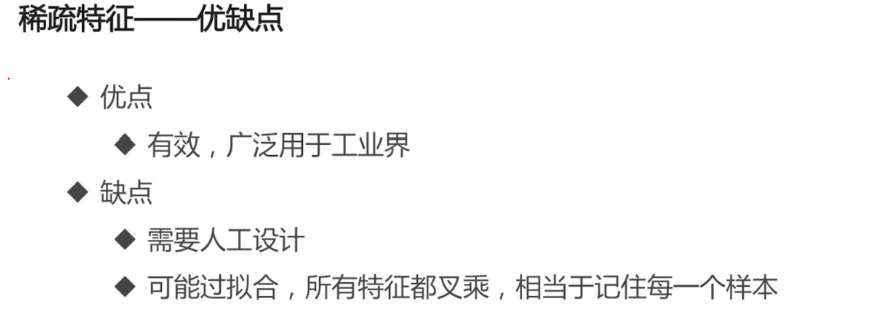

# 密集特征

1） 向量表达（在三维空间上进行表达）

    i) Eg： 词表={人工智能, 人文, 其它}
 
    ii) 人文=[0.3, 0.2, 0.6, (n维向量)]
    
2) Word2vec 工具（将词语转换成向量的工具，在三维空间中用向量之间的距离进行表示相关性）

密集特征优缺点

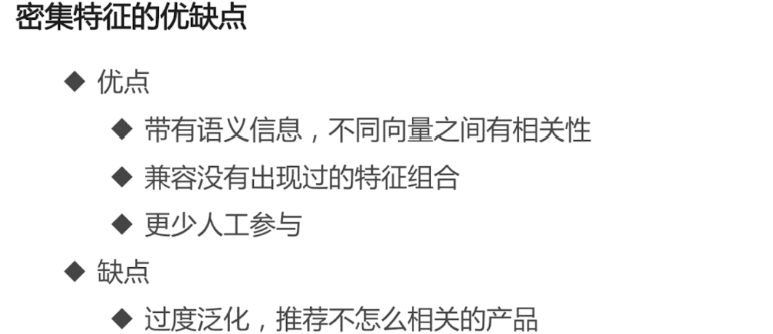

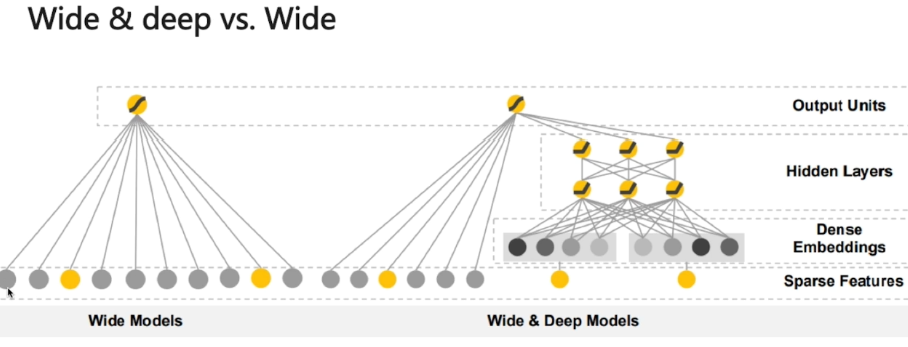

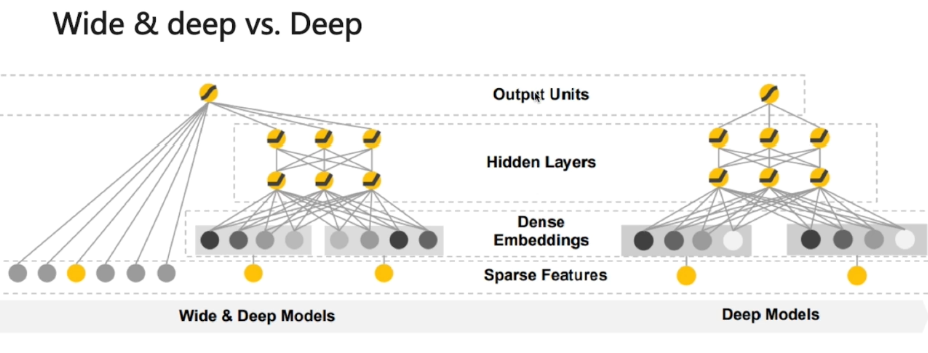

# 函数API实现wide&deep模型

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.0.0
sys.version_info(major=3, minor=6, micro=5, releaselevel='final', serial=0)
matplotlib 2.2.2
numpy 1.19.2
pandas 0.23.0
sklearn 0.23.2
tensorflow 2.0.0
tensorflow_core.keras 2.2.4-tf


In [2]:
# 导入房价预测数据集
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape) 
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
'''
参考链接：https://www.cnblogs.com/qi-yuan-008/p/11997248.html

train_test_split是sklearn中用于划分数据集，即将原始数据集划分成测试集和训练集两部分的函数。

2. 参数

train_size：训练集大小

　　float：0-1之间，表示训练集所占的比例

　　int：直接指定训练集的数量

　　None：自动为测试集的补集，也就是原始数据集减去测试集

test_size：测试集大小，默认值是0.25

　　float：0-1之间，表示测试集所占的比例

　　int：直接指定测试集的数量

　　None：自动为训练集的补集，也就是原始数据集减去训练集

random_state：可以理解为随机数种子，主要是为了复现结果而设置

shuffle：表示是否打乱数据位置，True或者False，默认是True

stratify：表示是否按照样本比例（不同类别的比例）来划分数据集，例如原始数据集 类A:类B = 75%:25%，

那么划分的测试集和训练集中的A:B的比例都会是75%:25%；可用于样本类别差异很大的情况，

一般使用为：stratify=y，即用数据集的标签y来进行划分。

3. 一般使用形式是：
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.75, random_state=14, stratify=y)
'''


from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


归一化

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [5]:
# 函数式API 功能API
input = keras.layers.Input(shape=x_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
# 复合函数: f(x) = h(g(x))

concat = keras.layers.concatenate([input, hidden2])
output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs = [input],
                           outputs = [output])

model.summary()
model.compile(loss="mean_squared_error", optimizer="sgd")
callbacks = [keras.callbacks.EarlyStopping(
    patience=5, min_delta=1e-2)]

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]                

In [6]:
history = model.fit(x_train_scaled, y_train,
                    validation_data = (x_valid_scaled, y_valid),
                    epochs = 100,
                    callbacks = callbacks)


Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 100us/sample - loss: 0.8151 - val_loss: 0.8511
Epoch 2/100
11610/11610 [==============================] - 0s 36us/sample - loss: 2.3236 - val_loss: 12.3974
Epoch 3/100
11610/11610 [==============================] - 0s 37us/sample - loss: nan - val_loss: nan
Epoch 4/100
11610/11610 [==============================] - 0s 38us/sample - loss: nan - val_loss: nan
Epoch 5/100
11610/11610 [==============================] - 0s 38us/sample - loss: nan - val_loss: nan
Epoch 6/100
11610/11610 [==============================] - 0s 38us/sample - loss: nan - val_loss: nan


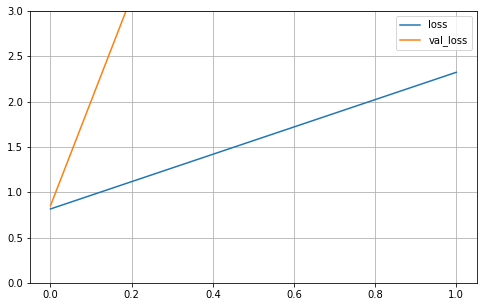

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 3)
    plt.show()
plot_learning_curves(history)

In [9]:
model.evaluate(x_test_scaled, y_test)

5160/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

nan